# __Group Assignment__

__Submission Date:__ 26/03/2025

__Assignment: NLP-2024-2025: Assignment 1__

__Group Members:__
- ANZALONE Gabriel
- MBENGUE Ndèye Arame

__Firm level topic of discussion:__ Technological Disruption

__Task__ : Measuring <u>Technological Disruption</u> with transcripts of Conference Calls.

### __1.1- Data Preparation and Text Cleaning__

In [2]:
# Code for Github
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 92.2 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
# Code for Github
! pip install nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 52.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
# Code for Github
!pip install statsmodels

#### __1.1.A- Loading data__

Management Presentations are the prepared, structured parts of the calls where management outlines key points. They tend to reflect the firm's official narrative on issues such as technological disruption.

Q&A Sessions are more spontaneous and can reveal additional insights or clarifications that may not be in the prepared presentation. They might capture unexpected concerns or deeper discussions on technology topics that aren’t as polished.

__We decided to go with both to ensure a certain level of robustness to our measure.__

In [1]:
import pandas as pd
# We import Earnings Calls and Q&A sessions of S&P500 from 2015 to 2021

# Loading Earning calls 
Sample_EC = pd.read_csv("https://www.dropbox.com/scl/fi/2p7ahxroqj9pwf98ni5an/Sample_Calls.csv?rlkey=zfieicvz891u4e3z0aroeg0u7&dl=1")

# Loading Presentations
Sample_Presentations = pd.read_feather("https://www.dropbox.com/scl/fi/uceh2xva5g4apbmt92cgt/Sample_Calls_Presentations.feather?rlkey=ln4nzsa4nenqyvm0pg2cur9sp&dl=1")

# Loading Q&As
Sample_QAs = pd.read_feather("https://www.dropbox.com/scl/fi/iq4111nlmsykp2tzxk9xg/Sample_Calls_QA.feather?rlkey=xabjqmwhesx05jivrlfzkgj6m&dl=1")

In [2]:
Sample_Presentations.head()

,file_name,presentation
0,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Good day and welcome to the Linear Technol...
1,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Welcome to Cerner Corporation's first quar...
2,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Welcome to Cerner Corporation's second qua...
3,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Welcome to Cerner Corporation's third quar...
4,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,Welcome to Cerner Corporation's fourth qua...


In [3]:
Sample_QAs.head()

,QA,speaker_name,file_name,QA_text,QA_number
0,q,david wong,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Thanks very much. Don, could you give us some ...",1
1,a,don zerio,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Yes, David, as you know we retired our convert...",1
2,q,david wong,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Great, thanks.",2
3,q,craig hettenbach,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Great thank you. Just a question on the commen...,3
4,a,lothar maier,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"When you think about China you know, particula...",3


#### __1.1.B- Filtering the data__

In [4]:
# filtering for answers only for the Q&A
temp = Sample_QAs[Sample_QAs['QA'] == 'a']

# Aggregating Answers by file_name
temp = temp.groupby('file_name')['QA_text'].apply(lambda x: ' '.join(x)).reset_index()

# Merging Back into the Main Dataset
Sample_answers = Sample_EC.merge(temp)

In [5]:
Sample_answers

,GVKEY,date_rdq,co_conm,file_name,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,IV,hvol,...,niq,epspxq,epspiq,dlttq,dlcq,prccq,cshoq,dvpq,xintq,QA_text
0,16101.0,2016-07-29 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.011886,0.014261,0.014261,0.021246,0.179151,0.129186,...,1610.0,0.99,0.99,37328.0,517.0,61.91,1628.542,0.0,245.0,"Jeff, this is Rick. I will cover the first and..."
1,16101.0,2016-04-28 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.026387,0.023499,0.023499,0.021770,0.289777,0.114447,...,1354.0,0.83,0.83,29490.0,2423.0,57.12,1617.359,0.0,215.0,"Okay. Hi, Jeff, it's Rick. So I'll take I gues..."
2,16101.0,2016-10-28 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.078668,-0.079290,-0.079290,-0.092594,0.253269,0.381002,...,1598.0,0.97,0.97,37284.0,26.0,63.07,1624.908,0.0,271.0,"Sure, Jami; this is Rick. Thank you for the qu..."
3,16101.0,2017-01-27 14:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,-0.010152,-0.000737,-0.000737,-0.005279,0.182080,0.145941,...,1391.0,0.85,0.85,36440.0,402.0,62.62,1592.513,0.0,277.0,"Hi, Jami; it's Bill. So on your operating marg..."
4,16101.0,2017-04-27 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,0.010397,0.010672,0.010672,0.012819,0.192822,0.112189,...,1711.0,1.07,1.07,36526.0,425.0,65.16,1591.366,0.0,273.0,"Yes. Well, first, thanks for the question. May..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,189491.0,2016-11-01 13:00:00+00:00,XYLEM INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.022716,-0.023069,-0.023069,-0.015313,0.238038,0.176583,...,73.0,0.41,0.41,1148.0,62.0,52.45,179.400,0.0,12.0,"Yes, well, thanks for the question, Jim. First..."
2873,189491.0,2016-08-02 13:00:00+00:00,XYLEM INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.036201,-0.034737,-0.034737,-0.037363,0.201698,0.213624,...,71.0,0.39,0.39,1143.0,91.0,44.65,179.200,0.0,12.0,"Sure, Deane. Let me just characterize what we ..."
2874,189491.0,2020-07-30 13:00:00+00:00,XYLEM INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,-0.030116,-0.028020,-0.028020,-0.049431,0.325614,0.345711,...,31.0,0.17,0.17,3031.0,269.0,64.96,180.000,0.0,18.0,"That is correct, Dean, on both counts. Sure. Y..."
2875,189491.0,2018-05-01 13:00:00+00:00,XYLEM INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2018...,-0.066260,-0.064927,-0.064927,-0.058477,0.206359,0.215869,...,79.0,0.44,0.44,2228.0,371.0,76.92,179.500,0.0,21.0,"Yes, I'll go first here, Nate. And I think the..."


In [6]:
# Filtering Presentations
Sample_Presentations = Sample_Presentations[
    Sample_Presentations['presentation'].str.split().apply(len) > 50 # filter to keep presentations with at least 50 words and to remove noise
].reset_index(drop=True)

# Grouping by file_name and concatenating presentation column (concatenating all text belonging to the same call into one large text entry)
Pres = Sample_Presentations.groupby("file_name")["presentation"].agg(lambda x: " ".join(x)).reset_index()
Pres.columns= ["file_name","text"]


#### __1.1.C- Prep-processing Textual Data__

In [7]:
# librairies
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize #breaking text into words
from nltk.stem import WordNetLemmatizer #reducing words to their base form

# Downloading data 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# We first tokenize words & remove the stopwords
stop_words = set(stopwords.words('english')) # preprocessing all words, removing the stopwords and using tokenization

def preprocess_text(text):
    tokens = word_tokenize(text.lower()) # putting all in lowercase format
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

Pres['tokens'] = Pres['text'].apply(preprocess_text)

Sample_answers['tokens'] = Sample_answers['QA_text'].apply(preprocess_text)

In [9]:
# Then we lemmatize to have a unified format
# Either use WordNetLemmatizer or Spacy -> better to use the latter to take the context of each word into account (POS Tagging)
# But it is way Longer than WordNet to run

lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

Pres['tokens'] = Pres['tokens'].apply(lemmatize_text)

Sample_answers['tokens'] = Sample_answers['tokens'].apply(lemmatize_text)

In [10]:
Pres['tokens'].head(10)

0    [lady, gentleman, thank, standing, welcome, fi...
1    [welcome, prudential, quarterly, earnings, cal...
2    [lady, gentleman, thank, standing, welcome, pr...
3    [lady, gentleman, thank, standing, welcome, q1...
4    [lady, gentleman, thank, standing, welcome, q2...
5    [thank, tom, good, morning, everyone, welcome,...
6    [welcome, southwest, airline, second, quarter,...
7    [thank, tom, good, morning, everyone, welcome,...
8    [lady, gentleman, thank, standing, welcome, an...
9    [lady, gentleman, thank, standing, welcome, an...
Name: tokens, dtype: object

In [11]:
Sample_answers['tokens'].head(10)

0    [jeff, rick, cover, first, third, one, mike, c...
1    [okay, hi, jeff, rick, take, guess, question, ...
2    [sure, jami, rick, thank, question, think, loo...
3    [hi, jami, bill, operating, margin, question, ...
4    [yes, well, first, thanks, question, maybe, le...
5    [okay, jami, thanks, much, question, try, take...
6    [okay, mike, maybe, start, talking, rate, cove...
7    [right, jami, rick, first, thank, compliment, ...
8    [right, thanks, jami, rick, appreciate, questi...
9    [rick, take, first, question, mike, cover, sec...
Name: tokens, dtype: object

In [12]:
Pres['text'].isnull().sum() # 0 null value

0

In [13]:
Sample_answers['QA_text'].isnull().sum() # 0 null value

0

### __1.2 - Measure Construction : Analysis & Market Reaction__

We decided to focus on the presentations first and then we could perform a parallel analysis with the Q&A texts to see if there are any notable differences in how technological disruption is discussed.

### __1.2.A - Intuitive (Naïve) method__ 

#### __1.2.A.1 Presentations Focus__

In [14]:
# We start with a set of seed words known to capture the essence of technological disruption

tech_dict = [
    "disrupt", "disruption",
    "innovate", "innovation",
    "digitize", "digital",
    "automation", "automate",
    "artificial", "intelligence",
    "machine", "learning",
    "blockchain", "cyber", 
    "robot", "iot", "tech"
]

In [15]:
# computing the score 
# We’ll define a function that takes the list of tokens for a given transcript and returns the frequency (or proportion) of tokens that are in our technology dictionary

def tech_score(tokens, tech_words):
    # Avoid division by zero
    if len(tokens) == 0:
        return 0
    # Count how many tokens are in the technology dictionary
    count = sum(1 for token in tokens if token in tech_words)
    # Return the proportion of tech-related words
    return count / len(tokens)


In [16]:
Pres['tech_score'] = Pres['tokens'].apply(lambda tokens: tech_score(tokens, tech_dict))
print(Pres[['file_name', 'tech_score']].head(10))

                                           file_name  tech_score
0  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
1  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
2  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
3  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.001849
4  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.002694
5  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
6  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
7  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
8  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
9  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000


__Merging with Firm-Level Data and Creating Quarter-Level Aggregates:__

We merge the presentation data (with our computed tech_score) with firm-level metadata from Sample_EC (which contains firm identifiers and the reporting date). Then, we convert the reporting date into a quarterly period and calculate the average disruption measure for each firm and quarter.

In [17]:
# Merge Pres (which has file_name and tech_score) with firm metadata
merged = pd.merge(
    Pres,
    Sample_EC[['file_name', 'GVKEY', 'co_conm', 'date_rdq', 'CAR-11-Carhart', 'SurpDec', 'IV']],
    on='file_name',
    how='left'
)


# Convert the reporting date to datetime and extract the quarter
merged['date_rdq'] = pd.to_datetime(merged['date_rdq'])
merged['quarter'] = merged['date_rdq'].dt.to_period('Q')

# Now, group by firm and quarter and calculate the average tech_score
firm_quarter = merged.groupby(['co_conm', 'quarter'])['tech_score'].mean().reset_index()

# Display the resulting DataFrame
print(firm_quarter.head())


      co_conm quarter  tech_score
0  ABBVIE INC  2016Q2    0.000327
1  ABBVIE INC  2016Q3    0.000000
2  ABBVIE INC  2016Q4    0.000000
3  ABBVIE INC  2017Q1    0.000000
4  ABBVIE INC  2017Q2    0.000000


/tmp/ipykernel_126869/3553359598.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged['quarter'] = merged['date_rdq'].dt.to_period('Q')


__Sorting Firms by Their Tech Score:__
    
We explore which firms have the highest or lowest technological disruption scores in a given quarter. 

In [18]:
# Sort the firm_quarter DataFrame by tech_score in descending order
sorted_firms = firm_quarter.sort_values(by='tech_score', ascending=False)
print("Top firms with high technological disruption score:")
print(sorted_firms.head(10))

print("\nFirms with low technological disruption score:")
print(sorted_firms.tail(10))

Top firms with high technological disruption score:
                       co_conm quarter  tech_score
622   COGNIZANT TECH SOLUTIONS  2017Q4    0.029772
621   COGNIZANT TECH SOLUTIONS  2017Q3    0.029437
619   COGNIZANT TECH SOLUTIONS  2017Q1    0.026060
624   COGNIZANT TECH SOLUTIONS  2018Q2    0.024725
1828           NIKE INC  -CL B  2020Q4    0.024182
620   COGNIZANT TECH SOLUTIONS  2017Q2    0.023854
625   COGNIZANT TECH SOLUTIONS  2018Q3    0.023284
1827           NIKE INC  -CL B  2020Q3    0.021989
623   COGNIZANT TECH SOLUTIONS  2018Q1    0.021947
1821           NIKE INC  -CL B  2019Q1    0.021900

Firms with low technological disruption score:
                     co_conm quarter  tech_score
1453        LILLY (ELI) & CO  2018Q4         0.0
1665   MONSTER BEVERAGE CORP  2016Q4         0.0
1669   MONSTER BEVERAGE CORP  2017Q4         0.0
1671   MONSTER BEVERAGE CORP  2018Q2         0.0
1672   MONSTER BEVERAGE CORP  2018Q3         0.0
1673   MONSTER BEVERAGE CORP  2018Q4         

__Visualizing the Aggregate Trend Over Time:__

We wan to see how the average technological disruption discussion evolves over time. To dos so, we compute the average tech score for each quarter across all firms and then plot a time series.

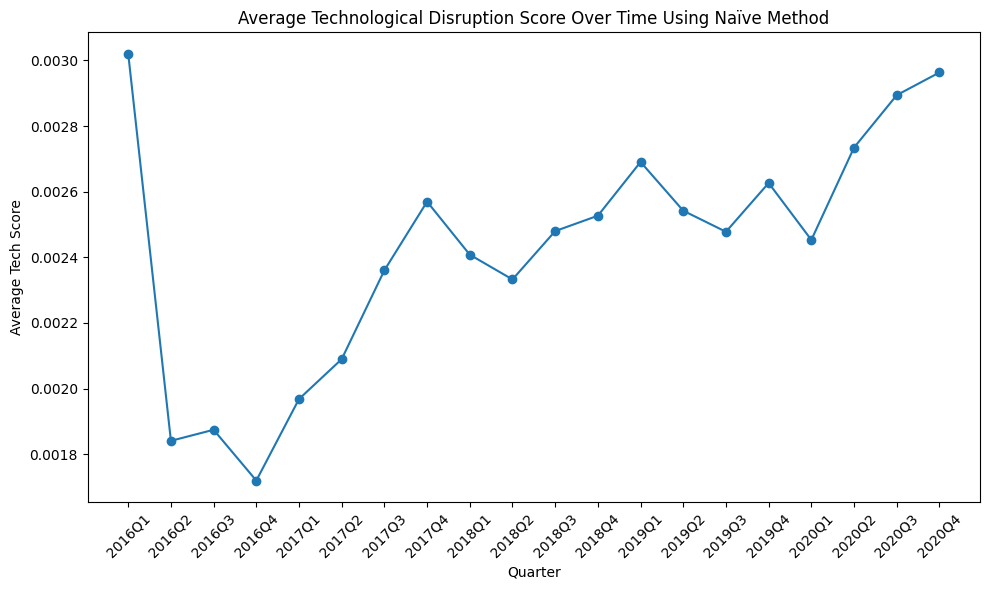

In [19]:
import matplotlib.pyplot as plt

# Group by quarter and calculate the average tech_score
agg_quarter = merged.groupby('quarter')['tech_score'].mean().reset_index()

# Convert quarter to string for better plotting on the x-axis
agg_quarter['quarter_str'] = agg_quarter['quarter'].astype(str)

plt.figure(figsize=(10,6))
plt.plot(agg_quarter['quarter_str'], agg_quarter['tech_score'], marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.title("Average Technological Disruption Score Over Time Using Naïve Method")
plt.xlabel("Quarter")
plt.ylabel("Average Tech Score")
plt.grid(False)
plt.tight_layout()
plt.show()


__Linking the Disruption Measure to Market Reaction:__

Our Sample_EC dataset contains market reaction variables such as CAR-11-Carhart and others. 
We can investigate whether firms that discuss technological disruption more tend to experience different market reactions. For instance, we can run a regression where the dependent variable is the abnormal return (CAR-11-Carhart), and the independent variable is your tech_score. We also decided to add control variables such as earnings surprises SurpDec later on.

In [20]:
import statsmodels.api as sm

# Drop any rows with missing values in the variables of interest
analysis_data = merged.dropna(subset=['CAR-11-Carhart', 'tech_score'])

# Define the independent and dependent variables
X = analysis_data[['tech_score']]  # You can add more controls like 'SurpDec' if desired
y = analysis_data['CAR-11-Carhart']

# Add a constant to the independent variables for the intercept
X = sm.add_constant(X)

# Fit the OLS regression model
ols_model = sm.OLS(y, X).fit()

# Print the regression summary
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.342
Date:                Mon, 24 Mar 2025   Prob (F-statistic):             0.0676
Time:                        20:17:08   Log-Likelihood:                 3894.3
No. Observations:                2816   AIC:                            -7785.
Df Residuals:                    2814   BIC:                            -7773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.001     -1.390      0.1

Looking at the table, we see that the independent variable (tech_score) explains only 0.1% of the variation in the dependent variable (CAR-11-Carhart). This is very low, suggesting that tech_score is not a strong predictor of CAR-11-Carhart with this measure.


The P-value of tech_score (0.068) indicates that tech_score is not statistically significant at the typical 5% level (0.05). It suggests that there is not enough evidence to conclude that tech_score has a meaningful effect on market reaction. Futhermore, The F-test evaluates the overall significance of the regression model. A p-value of 0.0676 is slightly above the 0.05 threshold, meaning the overall model is not statistically significant at the 5% level.
__This model does not provide a meaningful baseline for predicting CAR-11-Carhart.__




The regression output will show us if there is a statistically significant relationship between the discussion of technological disruption and market reaction. A significant coefficient (either positive or negative) on the tech_score could indicate that investors respond to the level of technological disruption discussion in earnings calls.

__Scatter Plot of Tech Score vs. CAR__


/tmp/ipykernel_126869/2312366390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data['quarter_str'] = analysis_data['quarter'].astype(str)


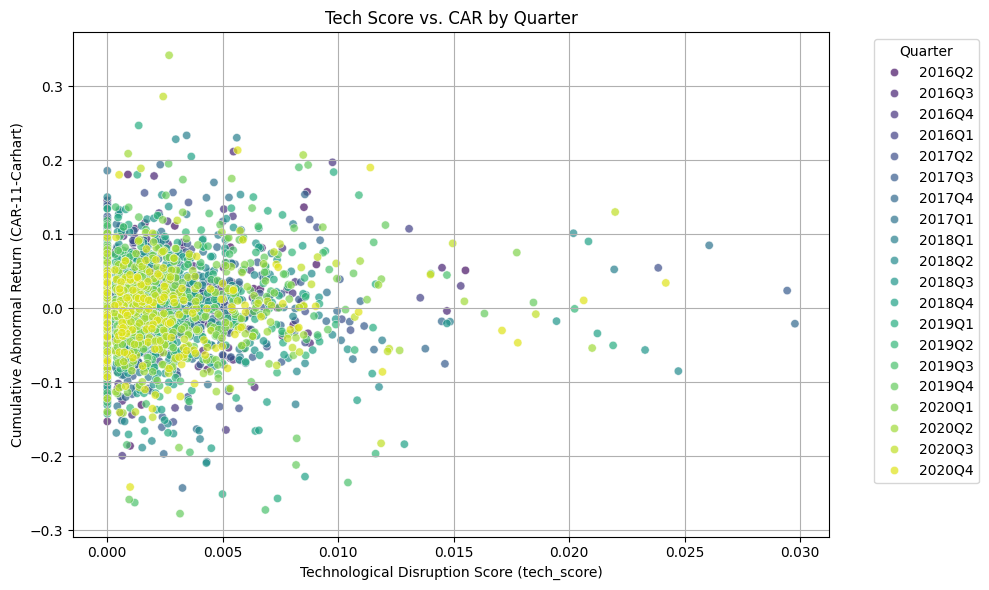

In [21]:
# Convert quarter to a categorical variable (if not already)
analysis_data['quarter_str'] = analysis_data['quarter'].astype(str)

# Create a color mapping for different quarters
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=analysis_data, x='tech_score', y='CAR-11-Carhart', hue='quarter_str', palette='viridis', alpha=0.7)
plt.xlabel("Technological Disruption Score (tech_score)")
plt.ylabel("Cumulative Abnormal Return (CAR-11-Carhart)")
plt.title("Tech Score vs. CAR by Quarter")
plt.grid(True)
plt.legend(title="Quarter", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


The data points appear widely scattered without a clear trend. This aligns with the low R-squared in our regression results, indicating that tech_score explains almost none of the variation in CAR.

__Incorporating Further Control Variables:__

As said prior, we will account for SurpDec (scaled earnings surprise), as firms with bigger surprises might have different market reactions, and implied volatility (IV) to capture the overall market risk environment or firm-specific uncertainty that could influence abnormal returns.

In [22]:
# You might need to adjust the merge step to include these variables.

# Drop rows with missing values in the variables of interest:
analysis_data = merged.dropna(subset=['CAR-11-Carhart', 'tech_score', 'SurpDec', 'IV'])

# Define your independent variables (including the tech score and controls)
control_vars = ['tech_score', 'SurpDec', 'IV']
X = analysis_data[control_vars]
y = analysis_data['CAR-11-Carhart']

# Add a constant term
X = sm.add_constant(X)

# Fit the regression model
model_controls = sm.OLS(y, X).fit()
print(model_controls.summary())


                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     67.52
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           3.89e-42
Time:                        20:17:09   Log-Likelihood:                 3937.7
No. Observations:                2772   AIC:                            -7867.
Df Residuals:                    2768   BIC:                            -7844.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0056      0.003     -1.828      0.0

The model now explains 6.8% of the variance in market reaction, compared to just 0.1% in the earlier model. While still low, it suggests that the newly added control variables contribute to a better explanation of CAR-11-Carhart. The model as a whole is now highly statistically significant, F-statistic (67.52, p-value = 3.89e-42), meaning that at least one of the independent variables contributes significantly to explaining CAR-11-Carhart.SurpDec is 0.0076, and the very low p-value (< 0.001) suggests that this variable has a strong, significant positive effect on CAR-11-Carhart.


#### __1.1.A.2- Q&A Focus__

In [23]:
# Applying the tech_score function to the Q&A tokens
# (We use the tokens already created in Sample_answers from your preprocessing steps)
Sample_answers['tech_score_qa'] = Sample_answers['tokens'].apply(lambda tokens: tech_score(tokens, tech_dict))

# Check a few examples
print("Sample Q&A Tech Scores:")
print(Sample_answers[['file_name', 'tech_score_qa']].head(10))

Sample Q&A Tech Scores:
                                           file_name  tech_score_qa
0  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...       0.000000
1  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...       0.000000
2  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...       0.000445
3  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...       0.000433
4  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...       0.000360
5  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...       0.000344
6  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...       0.000000
7  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2018...       0.000000
8  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2018...       0.001038
9  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2018...       0.000000


In [24]:
print(Pres.columns)

Index(['file_name', 'text', 'tokens', 'tech_score'], dtype='object')


In [25]:
# Convert the reporting date to datetime and extract the quarter for Q&A data
Sample_answers['date_rdq'] = pd.to_datetime(Sample_answers['date_rdq'])
Sample_answers['quarter'] = Sample_answers['date_rdq'].dt.to_period('Q')

# Group the Q&A data by quarter and calculate the average tech_score_qa
agg_qa = Sample_answers.groupby('quarter')['tech_score_qa'].mean().reset_index()

# Convert the quarter to a string for better labeling in plots
agg_qa['quarter_str'] = agg_qa['quarter'].astype(str)

print("Quarterly Aggregated Q&A Tech Scores:")
print(agg_qa.head())


Quarterly Aggregated Q&A Tech Scores:
  quarter  tech_score_qa quarter_str
0  2016Q1       0.003426      2016Q1
1  2016Q2       0.001830      2016Q2
2  2016Q3       0.002078      2016Q3
3  2016Q4       0.002146      2016Q4
4  2017Q1       0.002204      2017Q1


/tmp/ipykernel_126869/1263899962.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  Sample_answers['quarter'] = Sample_answers['date_rdq'].dt.to_period('Q')


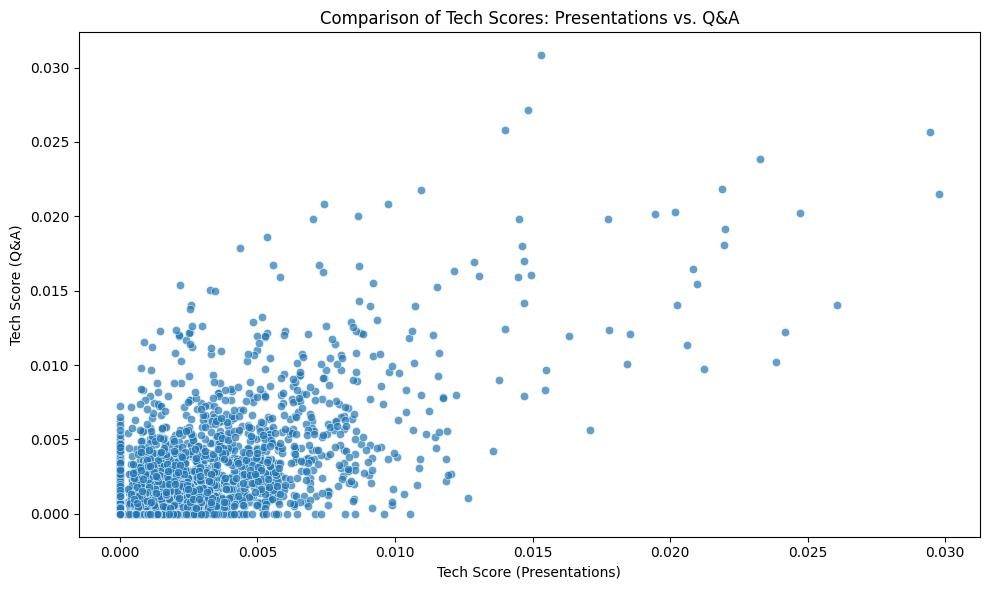

In [26]:
# Merge the presentation tech scores (from Pres) and Q&A tech scores (from Sample_answers) by file_name
merged_tech = pd.merge(Pres[['file_name', 'tech_score']], 
                       Sample_answers[['file_name', 'tech_score_qa']], 
                       on='file_name', how='inner')

plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_tech, x='tech_score', y='tech_score_qa', alpha=0.7)
plt.xlabel("Tech Score (Presentations)")
plt.ylabel("Tech Score (Q&A)")
plt.title("Comparison of Tech Scores: Presentations vs. Q&A")
plt.grid(False)
plt.tight_layout()
plt.show()


The majority of data points remain clustered in the lower-left quadrant, where both presentation and Q&A tech scores are close to zero.
This suggests that many presentations and Q&A sessions contain very few technology-related keywords.A few points show higher Q&A scores than presentation scores.This indicates that some Q&A sessions are more technology-focused than their corresponding presentations.

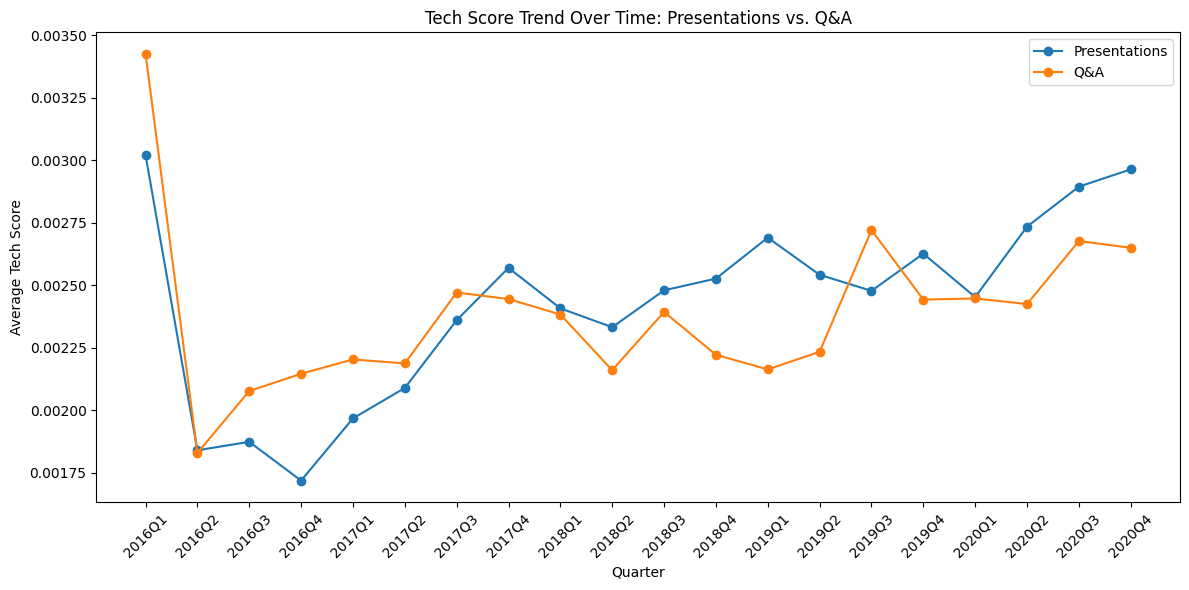

In [27]:
plt.figure(figsize=(12,6))
plt.plot(agg_quarter['quarter_str'], agg_quarter['tech_score'], marker='o', label='Presentations')
plt.plot(agg_qa['quarter_str'], agg_qa['tech_score_qa'], marker='o', label='Q&A')
plt.xticks(rotation=45)
plt.xlabel("Quarter")
plt.ylabel("Average Tech Score")
plt.title("Tech Score Trend Over Time: Presentations vs. Q&A")
plt.legend()
plt.tight_layout()
plt.show()


Both Presentation and Q&A tech scores show an increasing trend over time, indicating that technology-related discussions have become more prevalent.
Presentations Score Higher Than Q&A (Most Periods):
The Presentations is generally above the Q&A. This could mean that companies increasingly focus on technology in their official presentations rather than in unscripted discussions.

 #### __1.2.B- TF-IDF Weighted Count__

This method directly weighs words by how unique they are in the corpus, reducing the impact of very common words.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens back into text for TF-IDF processing
Pres['joined_text'] = Pres['tokens'].apply(lambda tokens: ' '.join(tokens))
Sample_answers['joined_text'] = Sample_answers['tokens'].apply(lambda tokens: ' '.join(tokens))

# TF-IDF Vectorizer (restricted to your tech-related dictionary)
vectorizer = TfidfVectorizer(vocabulary=tech_dict)

# Compute TF-IDF scores for presentations
tfidf_pres_matrix = vectorizer.fit_transform(Pres['joined_text'])
Pres['tfidf_score'] = tfidf_pres_matrix.sum(axis=1).A1  # Sum scores across your vocab

# Compute TF-IDF scores for Q&A sessions
tfidf_qa_matrix = vectorizer.fit_transform(Sample_answers['joined_text'])
Sample_answers['tfidf_score_qa'] = tfidf_qa_matrix.sum(axis=1).A1


We merge these TF-IDF scores back into firm-level data and aggregate at the firm-quarter level

In [29]:
# Merge with firm metadata
merged_tfidf = pd.merge(
    Pres[['file_name', 'tfidf_score']],
    Sample_EC[['file_name', 'GVKEY', 'co_conm', 'date_rdq', 'CAR-11-Carhart', 'SurpDec', 'IV']],
    on='file_name',
    how='left'
)

merged_tfidf['date_rdq'] = pd.to_datetime(merged_tfidf['date_rdq'])
merged_tfidf['quarter'] = merged_tfidf['date_rdq'].dt.to_period('Q')

# Aggregate at firm-quarter level
firm_quarter_tfidf = merged_tfidf.groupby(['co_conm', 'quarter'])['tfidf_score'].mean().reset_index()


/tmp/ipykernel_126869/267228270.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_tfidf['quarter'] = merged_tfidf['date_rdq'].dt.to_period('Q')


We sort and inspect the firms using TF-IDF scores:

In [31]:
top_tfidf_firms = firm_quarter_tfidf.sort_values(by='tfidf_score', ascending=False)
print("Firms with highest TF-IDF scores:", top_tfidf_firms.head(10))
print("Firms with lowest TF-IDF scores:", top_tfidf_firms.tail(10))


Firms with highest TF-IDF scores:                    co_conm quarter  tfidf_score
2837   XEROX HOLDINGS CORP  2020Q4     2.828875
2831   XEROX HOLDINGS CORP  2019Q2     2.780587
520            CERNER CORP  2019Q3     2.747011
2330    SALESFORCE.COM INC  2018Q4     2.738036
2828   XEROX HOLDINGS CORP  2018Q3     2.718418
896            EQUIFAX INC  2020Q4     2.694062
2746  WESTERN DIGITAL CORP  2019Q1     2.671104
889            EQUIFAX INC  2019Q1     2.562800
2103   PROCTER & GAMBLE CO  2017Q3     2.561165
2102   PROCTER & GAMBLE CO  2017Q2     2.542086
Firms with lowest TF-IDF scores:                     co_conm quarter  tfidf_score
2311        ROSS STORES INC  2019Q1          0.0
2312        ROSS STORES INC  2019Q2          0.0
2314        ROSS STORES INC  2019Q4          0.0
1836           NISOURCE INC  2018Q2          0.0
1837           NISOURCE INC  2018Q3          0.0
1838           NISOURCE INC  2018Q4          0.0
1829           NISOURCE INC  2016Q2          0.0
397          

We visualize how TF-IDF scores evolved over quarters:

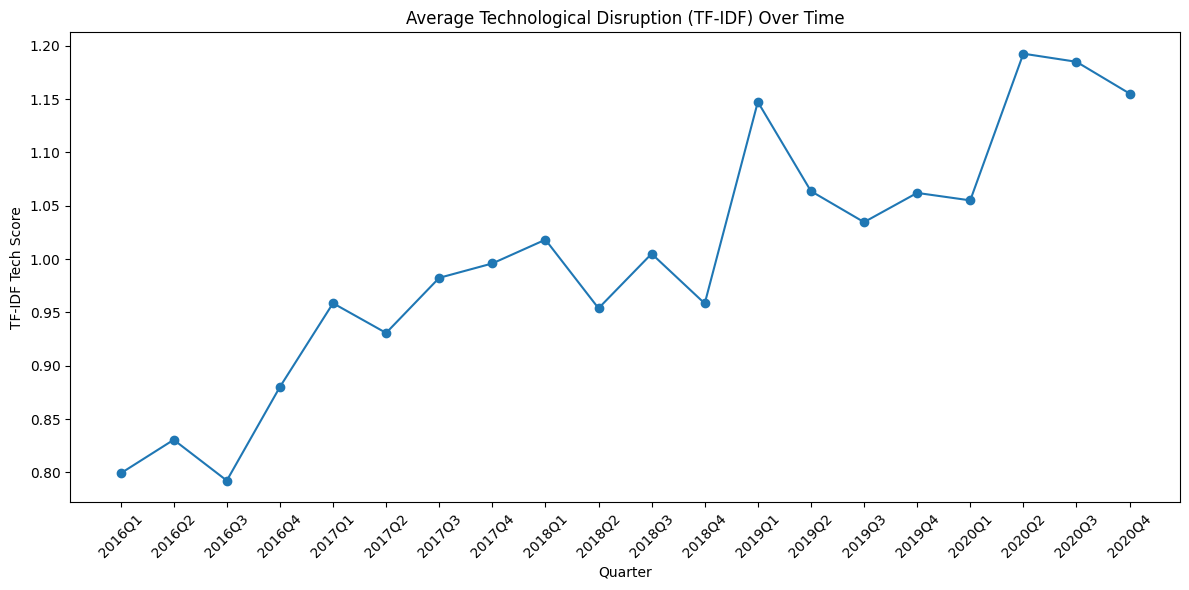

In [32]:
agg_tfidf_quarter = firm_quarter_tfidf.groupby('quarter')['tfidf_score'].mean().reset_index()
agg_tfidf_quarter['quarter_str'] = agg_tfidf_quarter['quarter'].astype(str)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(agg_tfidf_quarter['quarter_str'], agg_tfidf_quarter['tfidf_score'], marker='o')
plt.xticks(rotation=45)
plt.title("Average Technological Disruption (TF-IDF) Over Time")
plt.xlabel("Quarter")
plt.ylabel("TF-IDF Tech Score")
plt.tight_layout()
plt.show()


We perform regression analysis similar to the naive method to see the market reaction, using TF-IDF instead:

In [ ]:
analysis_data_tfidf = merged_tfidf.dropna(subset=['CAR-11-Carhart', 'tfidf_score', 'SurpDec', 'IV'])

# Define independent variables including controls
X_tfidf = analysis_data_tfidf[['tfidf_score', 'SurpDec', 'IV']]
y_tfidf = analysis_data_tfidf['CAR-11-Carhart']

X_tfidf = sm.add_constant(X_tfidf)

# Regression
model_tfidf = sm.OLS(y_tfidf, X_tfidf).fit()
print(model_tfidf.summary())


                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     67.21
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           6.02e-42
Time:                        20:21:47   Log-Likelihood:                 3937.2
No. Observations:                2772   AIC:                            -7866.
Df Residuals:                    2768   BIC:                            -7843.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0045      0.003     -1.345      

7. We aggregate and compare TF-IDF scores between Presentations and Q&A sessions graphically:

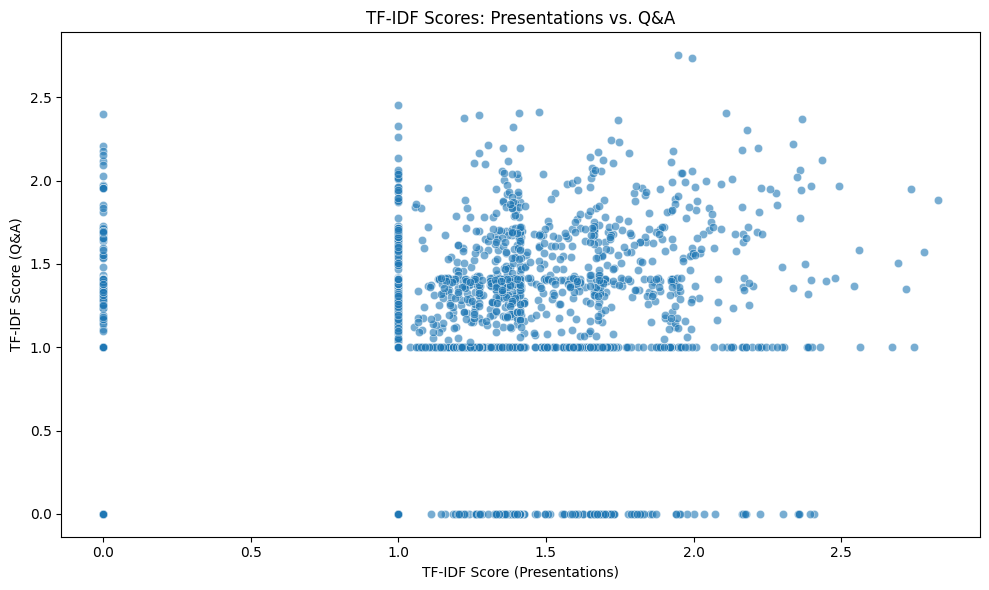

In [34]:
# Merge Presentation and Q&A TF-IDF scores
merged_tfidf_qa = pd.merge(
    Pres[['file_name', 'tfidf_score']],
    Sample_answers[['file_name', 'tfidf_score_qa']],
    on='file_name', how='inner'
)

plt.figure(figsize=(10,6))
import seaborn as sns
sns.scatterplot(data=merged_tfidf_qa, x='tfidf_score', y='tfidf_score_qa', alpha=0.6)
plt.xlabel("TF-IDF Score (Presentations)")
plt.ylabel("TF-IDF Score (Q&A)")
plt.title("TF-IDF Scores: Presentations vs. Q&A")
plt.tight_layout()
plt.show()


#### __1.2.C- Topic Modeling using LDA__

Idea:
Apply Latent Dirichlet Allocation (LDA) to extract topics from the transcripts. If one or more topics are clearly related to technological disruption, you can use the proportion of that topic in each document as your measure.
Step-by-Step:
Prepare the Corpus:
Use your preprocessed token lists (for example, the tokens column from your merged DataFrame).
Create a Gensim Dictionary and Corpus:
Convert the token lists into the format required by Gensim.
Train the LDA Model:
Choose the number of topics and train the model.
Identify Tech-Disruption Topics:
Inspect the topics and manually decide which ones reflect technological disruption.
Extract Topic Proportions:
For each document, extract the weight (proportion) of the tech-related topic(s).

In [38]:
import gensim
from gensim import corpora
import nltk

# Suppose Pres['tokens'] contains the tokenized words for each document
# Create a dictionary and corpus for LDA:
dictionary = corpora.Dictionary(Pres['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in Pres['tokens']]

# Train an LDA model (e.g., with 10 topics)
lda_model = gensim.models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10, random_state=42)

# Inspect topics
for i, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {i}: {topic}")

# Let's say through inspection you decide that Topic 3 represents tech disruption
tech_topic = 3

# For each document, get the proportion of the tech-related topic
def get_topic_proportion(doc_bow, topic_num):
    topic_distribution = lda_model.get_document_topics(doc_bow)
    # Return the weight for the desired topic
    for topic, weight in topic_distribution:
        if topic == topic_num:
            return weight
    return 0

Pres['tech_score_lda'] = [get_topic_proportion(doc, tech_topic) for doc in corpus]

print(Pres[['file_name', 'tech_score_lda']].head())


Topic 0: 0.027*"quarter" + 0.022*"year" + 0.014*"million" + 0.008*"billion" + 0.008*"business" + 0.006*"growth" + 0.006*"net" + 0.006*"result" + 0.006*"loan" + 0.006*"basis"
Topic 1: 0.012*"year" + 0.011*"quarter" + 0.009*"million" + 0.009*"customer" + 0.008*"earnings" + 0.007*"business" + 0.007*"share" + 0.006*"result" + 0.006*"slide" + 0.006*"growth"
Topic 2: 0.021*"year" + 0.012*"revenue" + 0.010*"million" + 0.009*"quarter" + 0.009*"new" + 0.008*"billion" + 0.007*"gaap" + 0.006*"call" + 0.006*"game" + 0.005*"growth"
Topic 3: 0.020*"year" + 0.017*"quarter" + 0.016*"sale" + 0.013*"million" + 0.011*"growth" + 0.009*"business" + 0.008*"margin" + 0.007*"market" + 0.007*"cost" + 0.006*"basis"
Topic 4: 0.021*"quarter" + 0.015*"million" + 0.014*"year" + 0.008*"market" + 0.008*"growth" + 0.008*"revenue" + 0.007*"result" + 0.007*"product" + 0.006*"billion" + 0.006*"cash"
Topic 5: 0.017*"year" + 0.016*"quarter" + 0.011*"growth" + 0.007*"share" + 0.006*"brand" + 0.006*"first" + 0.006*"market" +

Discussion:
Advantages: This approach is unsupervised and may capture broader themes, including co-occurring words that together indicate disruption.
Limitations: Topic labeling is subjective, and the model might not clearly separate tech disruption from other themes unless tuned carefully.

#### __1.2.D - Embedding-Based Similarity Measures__

Embeddings capture semantic relationships between words, better representing discussions around technological disruption even when specific keywords aren't explicitly mentioned.

Step 2.1: Load Pre-trained Word Embeddings
Use pre-trained embeddings like GloVe to capture general semantic meanings:

In [ ]:
import gensim.downloader as api

# Load pre-trained GloVe embeddings (fast and effective)
model = api.load('glove-wiki-gigaword-100')  # embedding dimension = 100


[==================================================] 100.0% 128.1/128.1MB downloaded


In [36]:
from sklearn.metrics.pairwise import cosine_similarity

In [37]:
# Compute a single embedding vector representing "Technological Disruption"
tech_concept_vector = np.mean(
    [model[word] for word in tech_dict if word in model],
    axis=0
)

# Function to compute the embedding vector of a document (list of tokens)
def doc_embedding(tokens, embedding_model):
    valid_tokens = [token for token in tokens if token in embedding_model]
    if not valid_tokens:
        return np.zeros(embedding_model.vector_size)
    return np.mean([embedding_model[token] for token in valid_tokens], axis=0)

# Apply to Presentations
Pres['doc_embedding'] = Pres['tokens'].apply(lambda tokens: doc_embedding(tokens, model))

# Apply to Q&A Answers
Sample_answers['doc_embedding'] = Sample_answers['tokens'].apply(lambda tokens: doc_embedding(tokens, model))

# Function to compute cosine similarity safely
def compute_similarity(doc_vec, concept_vec):
    if np.linalg.norm(doc_vec) == 0 or np.linalg.norm(concept_vec) == 0:
        return 0.0
    return cosine_similarity([doc_vec], [concept_vec])[0][0]

# Compute similarity scores for Presentations and Q&A using embeddings
Pres['embed_score'] = Pres['doc_embedding'].apply(lambda vec: compute_similarity(vec, tech_concept_vector))
Sample_answers['embed_score_qa'] = Sample_answers['doc_embedding'].apply(lambda vec: compute_similarity(vec, tech_concept_vector))

# Check scores briefly
print(Pres[['file_name', 'embed_score']].head())
print(Sample_answers[['file_name', 'embed_score_qa']].head())

                                           file_name  embed_score
0  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...     0.523277
1  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...     0.540666
2  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...     0.530940
3  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...     0.562542
4  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...     0.568431
                                           file_name  embed_score_qa
0  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...        0.600953
1  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...        0.591506
2  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...        0.594296
3  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...        0.608280
4  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...        0.599413


4. Firm-Level Aggregation of Embedding Scores

Merge with metadata and aggregate at firm-quarter level:

In [38]:
merged_embed = pd.merge(
    Pres[['file_name', 'embed_score']],
    Sample_EC[['file_name', 'GVKEY', 'co_conm', 'date_rdq', 'CAR-11-Carhart', 'SurpDec', 'IV']],
    on='file_name', how='left'
)

merged_embed['date_rdq'] = pd.to_datetime(merged_embed['date_rdq'])
merged_embed['quarter'] = merged_embed['date_rdq'].dt.to_period('Q')

# Aggregate embedding scores by firm and quarter
firm_quarter_embed = merged_embed.groupby(['co_conm', 'quarter'])['embed_score'].mean().reset_index()


/tmp/ipykernel_126869/2274810660.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_embed['quarter'] = merged_embed['date_rdq'].dt.to_period('Q')


5. Basic Analysis of Embedding Scores

Sort firms by their embedding-based disruption score:

In [39]:
top_embed_firms = firm_quarter_embed.sort_values(by='embed_score', ascending=False)
print("Firms with highest embedding disruption scores:", top_embed_firms.head(10))
print("Firms with lowest embedding disruption scores:", top_embed_firms.tail(10))


Firms with highest embedding disruption scores:                        co_conm quarter  embed_score
1959               NVIDIA CORP  2020Q2     0.699829
622   COGNIZANT TECH SOLUTIONS  2017Q4     0.688841
1961               NVIDIA CORP  2020Q4     0.686050
1958               NVIDIA CORP  2020Q1     0.682391
1956               NVIDIA CORP  2019Q3     0.676536
616   COGNIZANT TECH SOLUTIONS  2016Q2     0.675289
620   COGNIZANT TECH SOLUTIONS  2017Q2     0.675027
204                  ANSYS INC  2019Q2     0.673916
621   COGNIZANT TECH SOLUTIONS  2017Q3     0.673904
1955               NVIDIA CORP  2019Q2     0.670988
Firms with lowest embedding disruption scores:                         co_conm quarter  embed_score
1737                NETFLIX INC  2019Q2     0.484217
2643  UNIVERSAL HEALTH SVCS INC  2017Q3     0.483953
1739                NETFLIX INC  2019Q4     0.483851
1734                NETFLIX INC  2018Q3     0.483171
2645  UNIVERSAL HEALTH SVCS INC  2018Q1     0.481316
1735           

6. Aggregate Trend Over Time (Embedding Method)

Plot how embedding-based scores evolve quarterly:

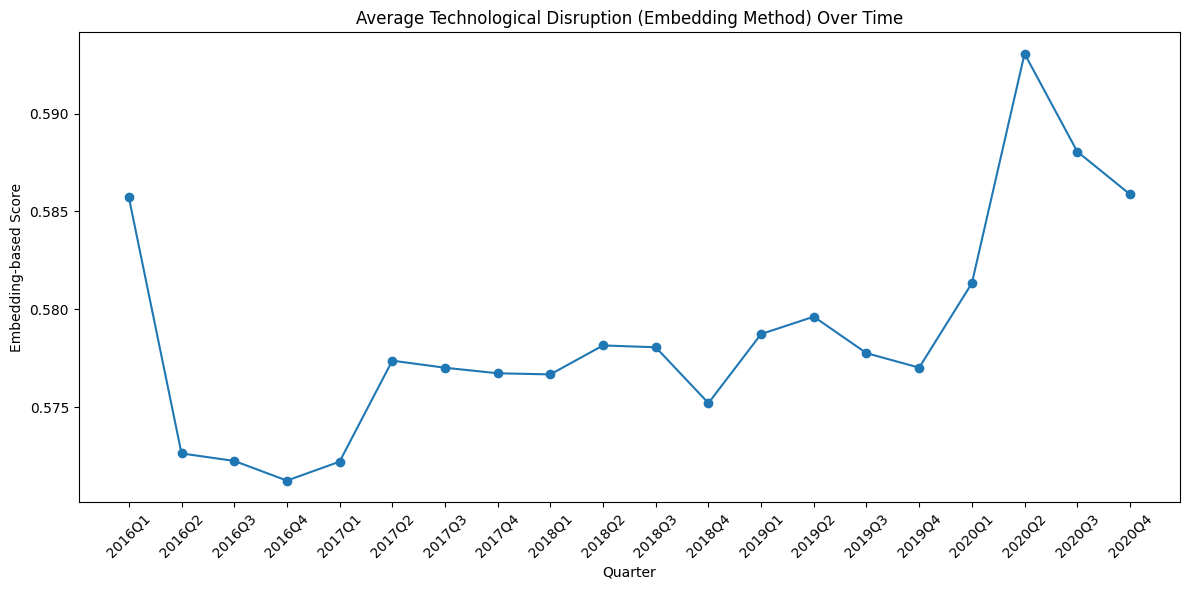

In [40]:
agg_embed_quarter = firm_quarter_embed.groupby('quarter')['embed_score'].mean().reset_index()
agg_embed_quarter['quarter_str'] = agg_embed_quarter['quarter'].astype(str)

plt.figure(figsize=(12,6))
plt.plot(agg_embed_quarter['quarter_str'], agg_embed_quarter['embed_score'], marker='o')
plt.xticks(rotation=45)
plt.title("Average Technological Disruption (Embedding Method) Over Time")
plt.xlabel("Quarter")
plt.ylabel("Embedding-based Score")
plt.tight_layout()
plt.show()


7. Embedding Scores & Market Reaction Analysis

Perform a regression analysis to assess if embedding-based scores predict market reactions:

In [41]:
analysis_data_embed = merged_embed.dropna(subset=['CAR-11-Carhart', 'embed_score', 'SurpDec', 'IV'])

X_embed = analysis_data_embed[['embed_score', 'SurpDec', 'IV']]
y_embed = analysis_data_embed['CAR-11-Carhart']

X_embed = sm.add_constant(X_embed)

# Regression analysis
model_embed = sm.OLS(y_embed, X_embed).fit()
print(model_embed.summary())


                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     67.20
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           6.09e-42
Time:                        20:43:01   Log-Likelihood:                 3937.2
No. Observations:                2772   AIC:                            -7866.
Df Residuals:                    2768   BIC:                            -7843.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0087      0.020     -0.436      

8. Comparison Between Presentations and Q&A Embedding Scores

Visually compare embedding scores between presentations and Q&A:

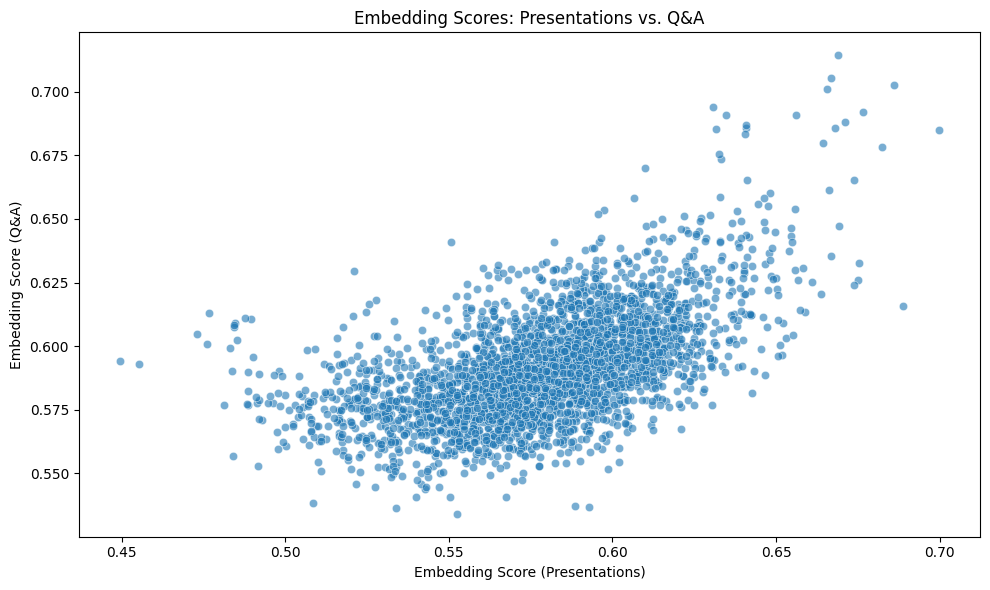

In [42]:
merged_embed_qa = pd.merge(
    Pres[['file_name', 'embed_score']],
    Sample_answers[['file_name', 'embed_score_qa']],
    on='file_name', how='inner'
)

plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_embed_qa, x='embed_score', y='embed_score_qa', alpha=0.6)
plt.xlabel("Embedding Score (Presentations)")
plt.ylabel("Embedding Score (Q&A)")
plt.title("Embedding Scores: Presentations vs. Q&A")
plt.tight_layout()
plt.show()


Idea:
Compute an average embedding for each transcript (using a Word2Vec or similar model), then measure its similarity to a reference vector that represents technological disruption. The reference vector can be created by averaging embeddings of a set of seed words related to tech disruption.
Step-by-Step:
Prepare Word Embeddings:
Either train a Word2Vec model on your corpus or use pre-trained embeddings. (Assume you already have a model.)
Create a Reference Vector:
Choose seed words (e.g., "innovation", "automation", "digital", "AI", "disruption") and compute their average embedding.
Compute Document Embeddings:
For each document, average the embeddings of the words (ignoring words not in the vocabulary).
Calculate Cosine Similarity:
Measure the cosine similarity between the document’s average embedding and the reference vector. Use that as your tech disruption measure.


Advantages: This method captures semantic nuances by using word embeddings. It can pick up on synonyms and contextual cues beyond a fixed keyword list.
Limitations: Averaging embeddings ignores word order and may be sensitive to noise if the document has many irrelevant words. Additionally, the quality of the measure depends on the embedding model and the chosen seed words.

#### 1.1.B - Using Cosine Similarity

- Using Google's Word2Vec API model to find words related to "technological disruption

In [1]:
%%capture
!pip uninstall -y numpy gensim scipy smart-open
!pip install numpy==1.25.2 scipy gensim smart-open
# After this, restart the session (restart kernel, don't delete runtime)

In [1]:
# Loading Google's pre-trained Word2Vec model with 300-dimensional vector
import gensim.downloader as api
google_model = api.load("word2vec-google-news-300")

: 

- Finding words similar to the key terms to help build a vocabulary related to "technological disruption".

In [2]:
# What we will do is select a bunch of words based on their similarity with Technological Disruption and add them to our tech dictionnary
# First using: "most_similar" function of google_model
# Limit = we can use only one word
print(google_model.most_similar("technological", topn=5))

NameError: name 'google_model' is not defined

In [ ]:
print(google_model.most_similar("disruption", topn=5))

[('disruptions', 0.8658042550086975), ('interruption', 0.658836841583252), ('interruptions', 0.6469897627830505), ('distruption', 0.6304445862770081), ('disrupted', 0.6218001842498779)]


In [ ]:
print(google_model.most_similar("technological_innovations", topn=5))

[('innovations', 0.7695900797843933), ('technological_advances', 0.7287052869796753), ('technological_advancements', 0.7118793725967407), ('technological_advancement', 0.6809303760528564), ('technologies', 0.6743346452713013)]


In [ ]:
# Lets say we want to create a bag of words that are closely linked to technological disruption:
# We can select among these and add our proper words to create a dictionnary:

keywords = ["disruption","technological","interruption","advancement","innovation","ai","automation", "robotics", "technology"]

Computing Cosine Similarity mean of this vector

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# If we take the mean of all of these keywords in the model, and word with the cosine similarity:
tech_vectors = np.mean([google_model[word] for word in keywords if word in google_model], axis=0)

def compute_similarity(tokens):
    vectors = np.array([google_model[word] for word in tokens if word in google_model])
    if vectors.size == 0:
        return 0  # Aucun mot trouvé dans le modèle
    avg_vector = np.mean(vectors, axis=0)
    similarity = cosine_similarity([avg_vector], [tech_vectors])[0][0]
    return similarity

Pres['tech_disruption_score'] = Pres['tokens'].apply(compute_similarity) # affecting a score to each

Filtering Companies based on their score

In [ ]:
Pres = Pres.merge(Sample_EC[['file_name', 'co_conm']], on='file_name', how='left') # we merge the data to get the names of the companies

sorted_pres = Pres.sort_values(by='tech_disruption_score', ascending=False) # filtering by the disruption score

top_10 = sorted_pres[['file_name', 'co_conm', 'tech_disruption_score']].head(10)
bottom_10 = sorted_pres[['file_name', 'co_conm', 'tech_disruption_score']].tail(10)

In [ ]:
print("These are the Top 10 companies related to Technological Disruption:")
print(top_10)

print("\nThese are the Bottom 10 companies related to Technological Disruption:")
print(bottom_10)

These are the Top 10 companies related to Technological Disruption:
                                              file_name  \
2557  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...   
1948  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2019...   
446   Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...   
2805  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...   
2595  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...   
695   Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...   
780   Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...   
1996  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2019...   
1464  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2018...   
510   Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...   

                       co_conm  tech_disruption_score  
2557               NVIDIA CORP               0.597319  
1948                 ANSYS INC               0.596867  
446                NVIDIA CORP               0.591857  
2805               NVIDIA CORP               0.588900  
25

<b>Comments on this:</b>
- We see pure technological players (what we would expect actually): Nvidia, Synopsis (operating in the semiconductor field)
- But we also observe Netflix within the Bottom 10, even though it ictually is related to technological disruption.

Piste d'amélioration à ce niveau : améliorer la recherche des keywords ?

In [ ]:
# Calculer la similarité cosinus entre la moyenne des vecteurs des mots-clés et tous les mots du modèle
def get_most_similar_words_to_avg_vector(model, avg_vector, top_n=10):
    similarities = {}
    for word in model.index_to_key:  # Iterer sur tous les mots dans le modèle
        word_vector = model[word]
        similarity = cosine_similarity([avg_vector], [word_vector])[0][0]  # Calculer la similarité cosinus
        similarities[word] = similarity

    # Trier les mots en fonction de la similarité cosinus et obtenir les 'top_n' mots les plus proches
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_similarities[:top_n]

# Obtenir les 10 mots les plus proches de la moyenne des vecteurs des mots-clés
most_similar_words = get_most_similar_words_to_avg_vector(google_model, tech_vectors, top_n=10)

# Afficher les mots les plus similaires à la moyenne des mots-clés
print("Most similar words to the average of technological disruption keywords:")
for word, similarity in most_similar_words:
    print(f"{word}: {similarity}")

In [ ]:
import matplotlib.pyplot as plt

# Ajouter une colonne 'quarter' à partir de la date
Pres['quarter'] = pd.to_datetime(Sample_EC['date_rdq']).dt.to_period('Q')

# Agréger les scores de disruption technologique par trimestre
quarterly_scores = Pres.groupby('quarter')['tech_disruption_score'].mean()

# Tracer les résultats
plt.figure(figsize=(10, 6))
quarterly_scores.plot(kind='line')
plt.title("Technological Disruption Over Time")
plt.xlabel("Quarter")
plt.ylabel("Average Technological Disruption Score")
plt.grid(True)
plt.show()


In [ ]:
# 4. Explorer la réaction du marché (exemple avec des rendements boursiers)
# Remplacer par les rendements boursiers réels si disponibles dans le dataset
Pres['stock_return'] = Sample_EC['CAR-11-Carhart']  # Exemple d'une variable de rendement

# Calculer la corrélation entre les scores de disruption technologique et les rendements boursiers
correlation = Pres['tech_disruption_score'].corr(Pres['stock_return'])
print(f"Correlation between tech disruption score and stock return: {correlation}")

In [ ]:
import statsmodels.api as sm

# 1. Préparer les données pour la régression
# Dépendant : CAR-11-Carhart (rendement boursier, ou autre variable)
# Indépendant : tech_disruption_score (score de disruption technologique)

# Ajouter les rendements boursiers réels ou toute autre variable financière
Pres['stock_return'] = Sample_EC['CAR-11-Carhart']  # Remplacer par les rendements réels si disponibles

# Supprimer les valeurs manquantes pour éviter les erreurs dans la régression
Pres.dropna(subset=['tech_disruption_score', 'stock_return'], inplace=True)

# Variables indépendantes (score de disruption technologique)
X = Pres[['tech_disruption_score']]

# Variable dépendante (rendement boursier)
y = Pres['stock_return']

# Ajouter une constante à la matrice des variables indépendantes pour le modèle
X = sm.add_constant(X)

# S'assurer que les indices sont cohérents après suppression des valeurs manquantes
y = y.loc[X.index]

# Convertir les variables en numériques (si nécessaire)
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# 2. Ajuster le modèle de régression (modèle OLS)
ols_model = sm.OLS(y, X).fit()

# 3. Afficher le résumé de la régression
print(ols_model.summary())


In [ ]:
# R squared = 0 and non significance...

2 - Using Doc2Vec